# Challenge Part 1: Language Model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

The idea of this challenge is to use deep learning (more specifically, the ULMFiT) so let's start. In this notebook I will load a pre-trained language model and fine-tuning with our specific Tweeter dataset.

In [3]:
INPUT_FILE = 'twitter-airline-sentiment/Tweets.csv'
VERSION = 'lm'

DATA_PATH = 'data/%s/' % VERSION

import os
os.makedirs(DATA_PATH, exist_ok=True)

## Text normalization

As opposed to the classic approach that might require careful pre-processing and feature extraction, a deep neural network gives us much more freedom. And fast.ai's `TextList` does most of the work for us: tokenization, cleaning up the strings, building the dictionary, numeralization/vectorization, etc.

In any case, I considered convenient to apply a very light pre-processing over the raw strings, namely:
- All the tweets have a handler with the airline's company at the beginning (e.g. `@VirginAmerica`), I am removing them as they bring no additional information and actually could make the models to overfit, learning to classify according to the airline's name instead of the actual sentiment of the text.
- `nltk` has a very handy `TweetTokenizer` ([documentation](https://www.nltk.org/api/nltk.tokenize.html)) that helps to clean up HTML tags and to respect/normalize emojis.
- Any other handlers are replaced by a placeholder `xxhan`.
- Any hashtag that looks like a word (e.g. `#angry`) has the initial `#` removed, since they normally carry regular meaning. Other hashtags are just kept, if they are too rare they will be replaced by UNK anyway.
- All URLs are replaced by `xxurl`.

In [4]:
from nltk.tokenize.casual import TweetTokenizer

REGEX_URL = re.compile(r'https?://|www.')
TOKEN_URL = 'xxurl'
TOKEN_HANDLE = 'xxhan'

def normalize_token(token):
    if token.startswith('@'):
        return TOKEN_HANDLE
    elif token.startswith('#') and token[1:].isalpha():
        return token[1:]
    elif re.match(REGEX_URL, token):
        return TOKEN_URL
    else:
        return token    

tokenizer = TweetTokenizer(preserve_case=True)

def normalize_text(text):
    tokens = tokenizer.tokenize(text)
    
    # if the first token is a handler, it's normally irrelevant
    if tokens[0].startswith('@'):
        tokens.pop(0)
    
    return ' '.join(normalize_token(t) for t in tokens)

Let's load the original CSV, extract the columns we care about and apply the pre-processing.

In [5]:
raw_data = pd.read_csv(INPUT_FILE, header=0)

df = raw_data.copy()[['text', 'airline_sentiment']]
df = df.rename(columns={'airline_sentiment': 'sentiment'})
df_raw = df.copy()

df['text'] = df['text'].apply(normalize_text)

print("DATA SIZE: " + str(df.shape))
df.head()

DATA SIZE: (14640, 2)


,text,sentiment
0,What xxhan said .,neutral
1,plus you've added commercials to the experienc...,positive
2,I didn't today ... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious "" en...",negative
4,and it's a really big bad thing about it,negative


We can also show a few tweets in more detail, to check the effect of the normalization:

In [6]:
def show_normalization(_df):
    for i, row in _df.iterrows():
        print(row.sentiment.upper() + ": " + row.text + '\n>> ' + normalize_text(row.text) + '\n')

show_normalization(df_raw.head(10))

NEUTRAL: @VirginAmerica What @dhepburn said.
>> What xxhan said .

POSITIVE: @VirginAmerica plus you've added commercials to the experience... tacky.
>> plus you've added commercials to the experience ... tacky .

NEUTRAL: @VirginAmerica I didn't today... Must mean I need to take another trip!
>> I didn't today ... Must mean I need to take another trip !

NEGATIVE: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
>> it's really aggressive to blast obnoxious " entertainment " in your guests ' faces & they have little recourse

NEGATIVE: @VirginAmerica and it's a really big bad thing about it
>> and it's a really big bad thing about it

NEGATIVE: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
>> seriously would pay $ 30 a flight for seats that didn't have this playing . it's really the only bad thing about flying VA

POSITI

Finally, we will save the already normalized data, for future use:

In [7]:
with open(DATA_PATH + 'tweet_data.pkl', 'wb') as f:
    pickle.dump(df, f)

## Loading the base model

As indicated in the paper and in fast.ai's documentation, I am using a pre-trained language model from a subset of Wikipedia (the famous [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)).

Note that for training the LM, we can use the **entire** dataset, even with the neutral tweets. Everything is useful.

In [8]:
# creating the data source
# let's use a batch size of 48 as suggested
bs = 48

data_lm = (TextList.from_df(df, cols=['text'], path=DATA_PATH)
           .split_by_rand_pct(valid_pct=0.1, seed=42)  # just for repeatibility
           .label_for_lm()
           .databunch(bs=bs))

Let's see a few entries:

In [9]:
data_lm.show_batch()

idx,text
0,"$ 30 a flight for seats that did n't have this playing . it 's really the only bad thing about flying xxup va xxbos yes , nearly every time i fly xxup vx this “ xxunk xxunk ” won ’ t go away :) xxbos xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk , there . xxurl xxbos it was amazing , and"
1,"xxbos trying to check - in ... but looks like your site is down ? xxbos spending my birthday night with you , xxup dal - xxup dca . xxmaj get me home ! xxbos xxmaj sent a couple messages to the email you provided but to no avail . xxmaj will try again next year . xxmaj cheers . xxbos first time flying xxmaj virgin , went to xxunk"
2,"i got an email at xxunk am that the flight was xxmaj cancelled xxmaj flightled , does n't matter now flight into atl is delayed , thx xxbos 1k and had problem getting out of xxup fll to xxup iah sent xxup dm to you about making my connection please let me know xxbos xxmaj done and done xxbos thanks , just sent :) xxbos i 'm grounded in xxmaj"
3,an apology . i will never fly with your airline again . unitedairlines xxbos has the xxup worst customer xxunk ! xxmaj this xxmaj xxunk rep at call center must be investigated . xxmaj my baggage 's lost and there 's no help but argument ! xxbos should xxup not sell tickets for xxhan on xxurl . has terrible service and xxup ua staff can not reach xxmaj silver xxbos
4,"taking my 1 k status to xxhan neveragain xxup worstcustomerservice xxbos xxmaj hi ! what is the phone number for reservations in xxmaj xxunk ? xxmaj thanks xxbos can i request a ticket change through twitter ? xxbos xxup xxunk xxmaj flight was a nightmare ! ! xxmaj from poor customer service , having my confirmed seat given away ... + more issues xxbos to start daily # xxup xxunk"


In [10]:
data_lm.save('data_lm.pkl')

## Fine tuning

We can leverage fast.ai's `language_model_learner` that already includes the pre-trained model based on WT103, and the architecture as described in the paper, using a AWD_LSTM with drop-out and an AdamOptimizer.

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, path=DATA_PATH)

Let's use standard tooling to find our hyper-parameters (in this case, the learning rate) for the fine tuning.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-02
Min loss divided by 10: 4.37E-02


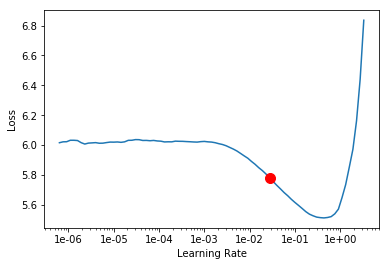

In [13]:
learn.recorder.plot(suggestion=True)

Both the plot and the suggested value give us the hint of `3E-02` for the learning rate. The empirically found values for momentum seem to be working fine as well.

In [14]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.344635,3.991299,0.253111,00:13


In [15]:
learn.save('fit_head')
learn.load('fit_head');

Time to fine tune the model with our Twitter data:

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(30, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.829806,3.930231,0.261445,00:17
1,3.768957,3.874933,0.270292,00:17
2,3.685932,3.825279,0.278003,00:17
3,3.595220,3.784717,0.284416,00:17
4,3.485023,3.764398,0.288258,00:17
5,3.340658,3.766773,0.289096,00:17
6,3.144660,3.794972,0.287744,00:18
7,2.916090,3.872813,0.283414,00:18
8,2.648367,3.958725,0.281006,00:18
9,2.397522,4.078024,0.278788,00:18


In [18]:
learn.save('fine_tuned')
learn.load('fine_tuned');

In the same spirit than the fast.ai examples, we can quickly check how good is our model in "predicting" the next word of a sentence, given a start:

In [19]:
N_WORDS = 50
N_SENTENCES = 3
TEXTS = ["My flight was", "I tried to"]

for text in TEXTS:
    for _ in range(N_SENTENCES):
        sentence = learn.predict(text, N_WORDS, temperature=0.75)
        print(sentence + '\n---')

My flight was Cancelled Flightled and i 'm calling o waiting for me to talk to someone about my flight . Should i be at work today . xxbos i am still sitting in the airport in 2 minutes . i 'm sorry , but i called to reserve the
---
My flight was Cancelled Flightled and i 'm needing some help reflight Booking Problems . xxbos i really want it together . Buying Early Bird was AMAZING . You guys are the best ! xxbos It 's not the weather . The
---
My flight was Cancelled Flightled Monday . Just hung up on me . xxbos But we are and are , being put on security , faithful . Staff is great ! xxbos xxhan Do you know when the last chance is ? xxbos since when does
---
I tried to book a non - profit ( they only gave me credit card ) and told me to call the website that i paid . Terrible service xxbos Why have n't you issued a travel advisory for Charlotte Wednesday night and Thursday ? 4 - 6
---
I tried to check in , but they redirect me to call in to xxhan , which i also ca n't get into contac

In [20]:
learn.save_encoder('fine_tuned_enc')